In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np
import os 

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [6]:
root_folder = 'FC_GAN_results'
fixed_folder = root_folder + '/Fixed_results'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)

In [7]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

In [8]:
lr = 0.0001
prior_size = 100
train_epoch = 1000
batch_size = 250
count_class = 10
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, transform=mnist_tanh)
fixed_z = torch.randn((50, 100))

In [9]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, last_fn=None):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
    
    def label2vec(self, batch):
        b = np.zeros((len(batch), count_class))
        b[np.arange(len(batch)), torch.Tensor.numpy(batch)] = 1
        return torch.Tensor(b)
    
    def forward(self, x, y):
        if self.flatten:
            x = torch.cat([x.view(x.shape[0], -1), self.label2vec(y)], 1)
        return self.model(x)

In [16]:
G = FullyConnected([prior_size, 256, 512, 1024, 28*28], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh())
D = FullyConnected([28*28+count_class, 1024, 512, 256, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), flatten=True)

G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)

In [17]:
train_log = {'G': [], 'D': []}
test_log = {'G': [], 'D': []}

In [18]:
batch_zeros = torch.zeros((batch_size, 1))
batch_ones = torch.ones((batch_size, 1))

In [25]:
def train(epoch, G, D, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        # train D
        D.zero_grad()
        G.zero_grad()
        z = torch.randn((batch_size, prior_size))
        fake_pred = D(G(z, target), target)
        true_pred = D(data, target)
        
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        D_loss = 0.5*(fake_loss + true_loss)
        
        D_loss.backward()
        D_optimizer.step()
        
        # train G
        D.zero_grad()
        G.zero_grad()
        z = torch.randn((batch_size, prior_size))
        fake_pred = D(G(z, target), target)
        G_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_ones)
        
        G_loss.backward()
        
        G_optimizer.step()
            
        if batch_idx % 100 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = 'G: {:.4f}, D: {:.4f}'.format(G_loss.item(), D_loss.item())
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = 'G: {:.4f}, D: {:.4f}'.format(G_loss.item(), D_loss.item())
        print(line + losses)
        log['G'].append(G_loss.item())
        log['D'].append(D_loss.item())

In [28]:
def test(G, D, loader, epoch, log=None):
    test_size = len(loader)
    G_loss = 0.
    D_loss = 0.
    test_loss = {'G': 0., 'D': 0.}
    with torch.no_grad():
        for data, target in loader:
            z = torch.randn((batch_size, prior_size))
            fake_pred = D(G(z, target), target)
            true_pred = D(data, target)
        
            fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros).item()
            true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones).item()
            
            D_loss += 0.5*(fake_loss + true_loss)
            G_loss += F.binary_cross_entropy_with_logits(fake_pred, batch_ones).item()
    
    G_loss /= test_size
    D_loss /= test_size

    fixed_gen = G(fixed_z, target).data.numpy().reshape(50, 1, 28, 28)
    plot_mnist(fixed_gen, (5, 10), True, fixed_folder + '/%03d.png' % epoch)
    report = 'Test losses. G: {:.4f}, D: {:.4f}'.format(G_loss, D_loss)
    print(report)

Train Epoch: 1 [0/50000 (0%)]	Losses G: 1.3571, D: 0.3157
Train Epoch: 1 [25000/50000 (50%)]	Losses G: 2.6644, D: 0.1503
Train Epoch: 1 [50000/50000 (100%)]	Losses G: 4.6783, D: 0.0327


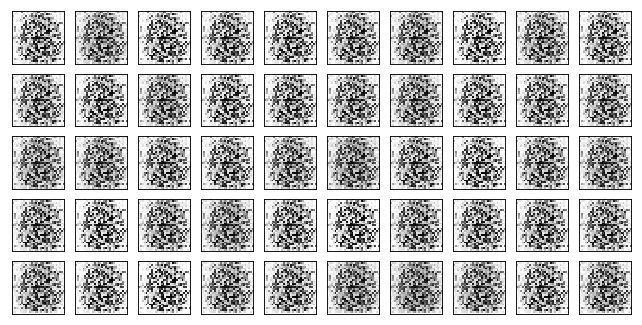

Test losses. G: 4.1151, D: 0.0181
Train Epoch: 2 [0/50000 (0%)]	Losses G: 4.6602, D: 0.0404
Train Epoch: 2 [25000/50000 (50%)]	Losses G: 3.6649, D: 0.0506
Train Epoch: 2 [50000/50000 (100%)]	Losses G: 7.4034, D: 0.0626


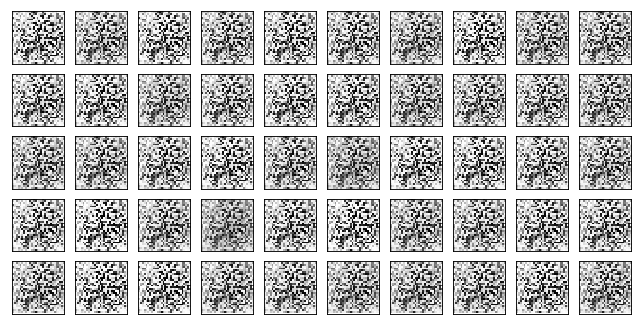

Test losses. G: 4.1085, D: 0.0385
Train Epoch: 3 [0/50000 (0%)]	Losses G: 6.8555, D: 0.1065
Train Epoch: 3 [25000/50000 (50%)]	Losses G: 5.7797, D: 0.0499
Train Epoch: 3 [50000/50000 (100%)]	Losses G: 5.4861, D: 0.0559


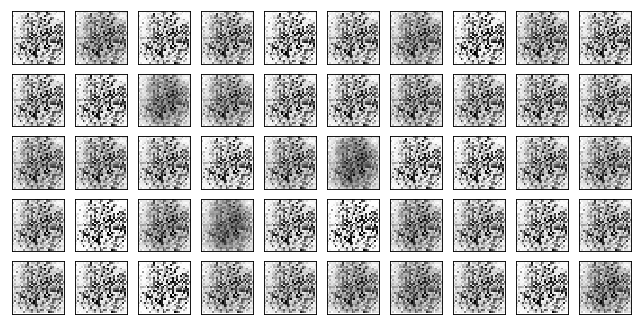

Test losses. G: 4.0973, D: 0.0242
Train Epoch: 4 [0/50000 (0%)]	Losses G: 5.4371, D: 0.0438
Train Epoch: 4 [25000/50000 (50%)]	Losses G: 5.3358, D: 0.0895
Train Epoch: 4 [50000/50000 (100%)]	Losses G: 5.5957, D: 0.0660


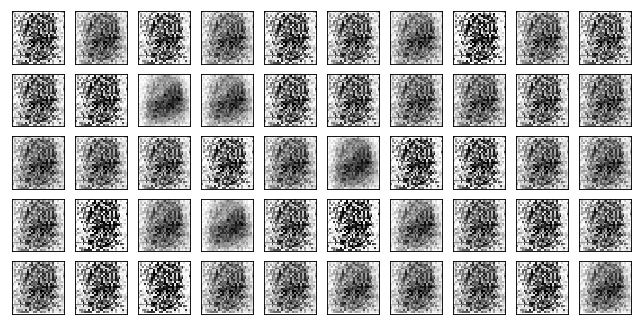

Test losses. G: 3.9556, D: 0.0384
Train Epoch: 5 [0/50000 (0%)]	Losses G: 6.0922, D: 0.0586
Train Epoch: 5 [25000/50000 (50%)]	Losses G: 4.4295, D: 0.0829
Train Epoch: 5 [50000/50000 (100%)]	Losses G: 4.6062, D: 0.1094


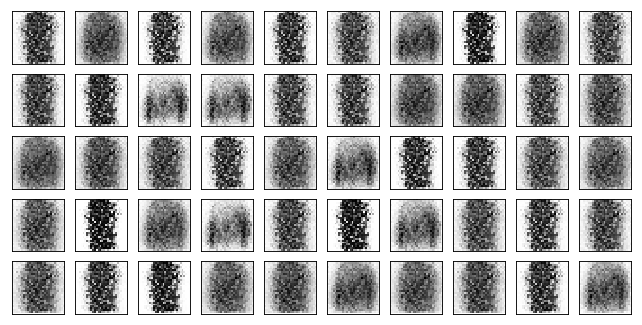

Test losses. G: 3.8198, D: 0.0675
Train Epoch: 6 [0/50000 (0%)]	Losses G: 4.5639, D: 0.0827
Train Epoch: 6 [25000/50000 (50%)]	Losses G: 5.8058, D: 0.1643
Train Epoch: 6 [50000/50000 (100%)]	Losses G: 4.3801, D: 0.1209


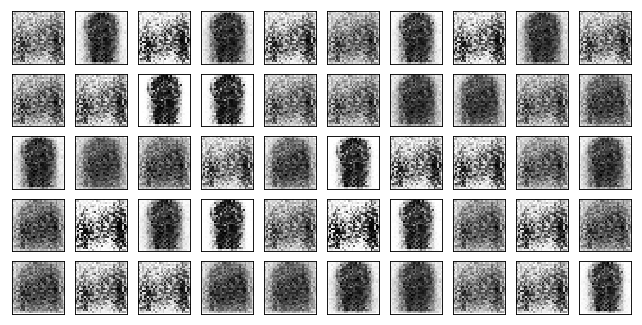

Test losses. G: 3.1532, D: 0.0726
Train Epoch: 7 [0/50000 (0%)]	Losses G: 3.9840, D: 0.0935
Train Epoch: 7 [25000/50000 (50%)]	Losses G: 5.1687, D: 0.1650
Train Epoch: 7 [50000/50000 (100%)]	Losses G: 6.1489, D: 0.0595


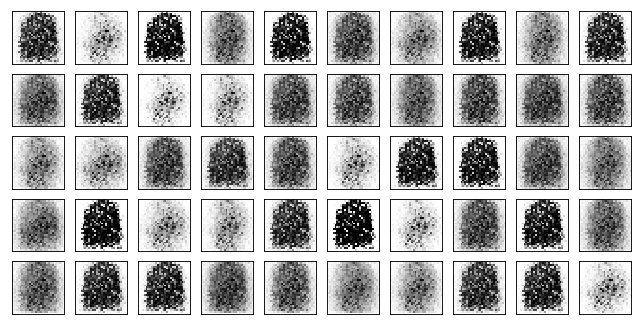

Test losses. G: 4.4696, D: 0.0435
Train Epoch: 8 [0/50000 (0%)]	Losses G: 5.8764, D: 0.1019
Train Epoch: 8 [25000/50000 (50%)]	Losses G: 6.8179, D: 0.1096
Train Epoch: 8 [50000/50000 (100%)]	Losses G: 5.4728, D: 0.0805


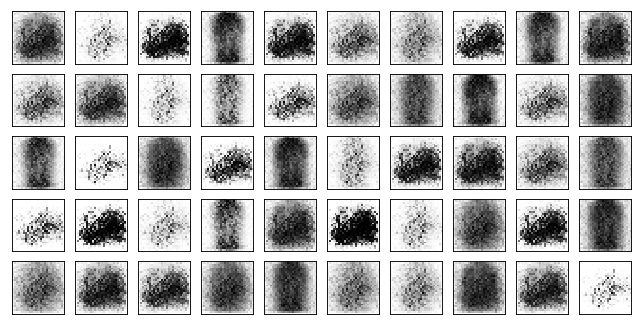

Test losses. G: 4.4595, D: 0.0538
Train Epoch: 9 [0/50000 (0%)]	Losses G: 5.2339, D: 0.1596
Train Epoch: 9 [25000/50000 (50%)]	Losses G: 5.1124, D: 0.0760
Train Epoch: 9 [50000/50000 (100%)]	Losses G: 5.0440, D: 0.1023


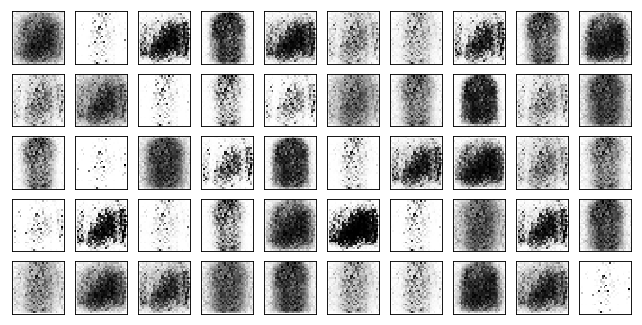

Test losses. G: 4.4243, D: 0.0355
Train Epoch: 10 [0/50000 (0%)]	Losses G: 4.9934, D: 0.0936
Train Epoch: 10 [25000/50000 (50%)]	Losses G: 5.5377, D: 0.0536
Train Epoch: 10 [50000/50000 (100%)]	Losses G: 5.3056, D: 0.0801


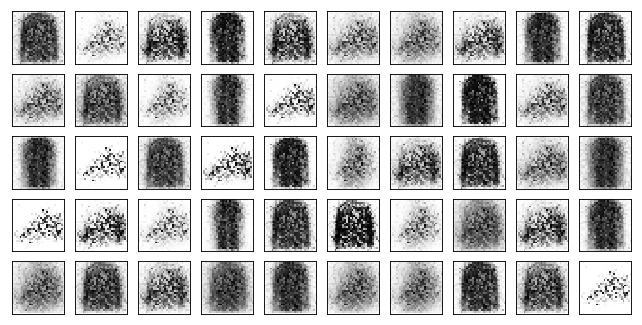

Test losses. G: 4.2890, D: 0.0339
Train Epoch: 11 [0/50000 (0%)]	Losses G: 5.4074, D: 0.0816
Train Epoch: 11 [25000/50000 (50%)]	Losses G: 4.4506, D: 0.0657
Train Epoch: 11 [50000/50000 (100%)]	Losses G: 4.9255, D: 0.1019


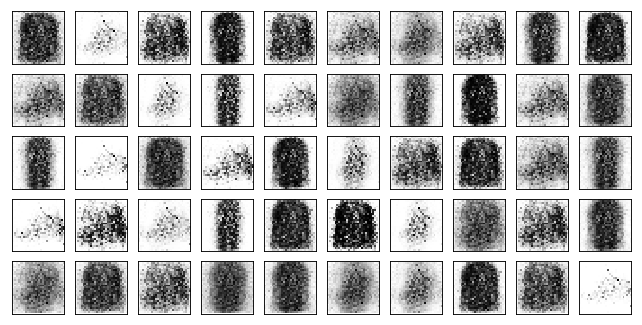

Test losses. G: 4.1467, D: 0.0404
Train Epoch: 12 [0/50000 (0%)]	Losses G: 4.7662, D: 0.0629
Train Epoch: 12 [25000/50000 (50%)]	Losses G: 5.5889, D: 0.1087
Train Epoch: 12 [50000/50000 (100%)]	Losses G: 4.6463, D: 0.1010


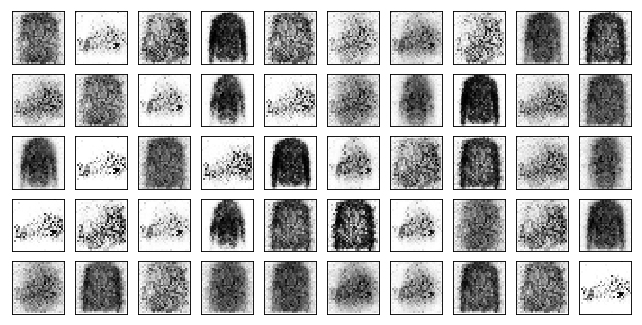

Test losses. G: 4.2014, D: 0.0469
Train Epoch: 13 [0/50000 (0%)]	Losses G: 4.7361, D: 0.0836
Train Epoch: 13 [25000/50000 (50%)]	Losses G: 4.1340, D: 0.1523
Train Epoch: 13 [50000/50000 (100%)]	Losses G: 4.9628, D: 0.0906


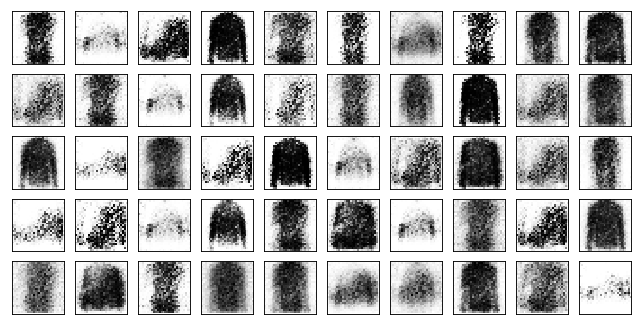

Test losses. G: 4.3282, D: 0.0590
Train Epoch: 14 [0/50000 (0%)]	Losses G: 5.0066, D: 0.0960
Train Epoch: 14 [25000/50000 (50%)]	Losses G: 3.8512, D: 0.1128
Train Epoch: 14 [50000/50000 (100%)]	Losses G: 4.0731, D: 0.1333


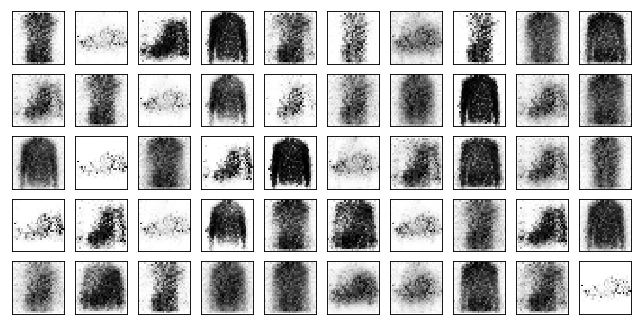

Test losses. G: 3.5759, D: 0.0823
Train Epoch: 15 [0/50000 (0%)]	Losses G: 3.8064, D: 0.1627
Train Epoch: 15 [25000/50000 (50%)]	Losses G: 3.2324, D: 0.1200
Train Epoch: 15 [50000/50000 (100%)]	Losses G: 4.8204, D: 0.0900


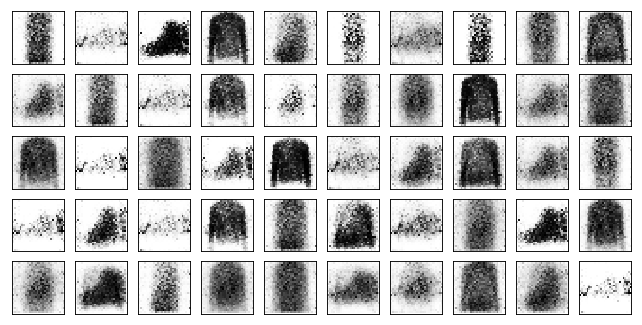

Test losses. G: 4.3131, D: 0.0455
Train Epoch: 16 [0/50000 (0%)]	Losses G: 4.5911, D: 0.0889
Train Epoch: 16 [25000/50000 (50%)]	Losses G: 3.4693, D: 0.1886
Train Epoch: 16 [50000/50000 (100%)]	Losses G: 4.7374, D: 0.1447


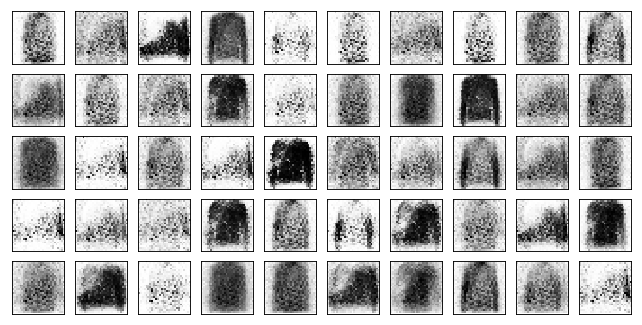

Test losses. G: 3.9776, D: 0.0617
Train Epoch: 17 [0/50000 (0%)]	Losses G: 4.4410, D: 0.1428
Train Epoch: 17 [25000/50000 (50%)]	Losses G: 4.6971, D: 0.1724
Train Epoch: 17 [50000/50000 (100%)]	Losses G: 4.3518, D: 0.1186


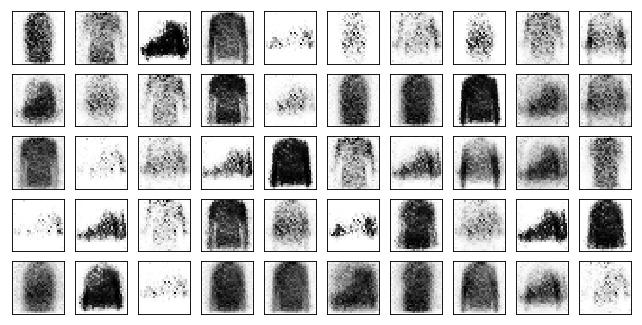

Test losses. G: 3.8184, D: 0.0554
Train Epoch: 18 [0/50000 (0%)]	Losses G: 4.2806, D: 0.1106
Train Epoch: 18 [25000/50000 (50%)]	Losses G: 4.2970, D: 0.0835
Train Epoch: 18 [50000/50000 (100%)]	Losses G: 5.1067, D: 0.1390


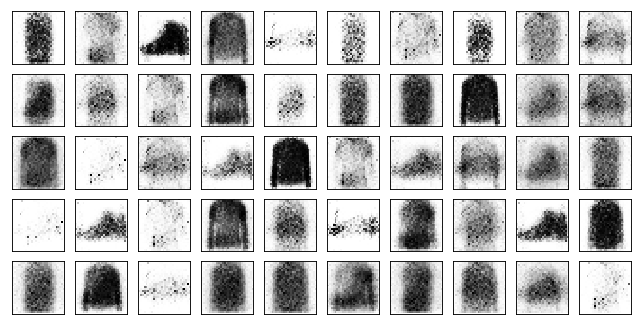

Test losses. G: 4.8754, D: 0.0638
Train Epoch: 19 [0/50000 (0%)]	Losses G: 4.4074, D: 0.1182
Train Epoch: 19 [25000/50000 (50%)]	Losses G: 4.6846, D: 0.1151
Train Epoch: 19 [50000/50000 (100%)]	Losses G: 4.0668, D: 0.1913


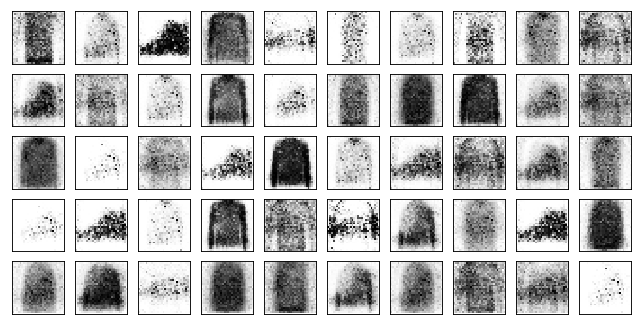

Test losses. G: 3.4720, D: 0.0790
Train Epoch: 20 [0/50000 (0%)]	Losses G: 4.3084, D: 0.1300
Train Epoch: 20 [25000/50000 (50%)]	Losses G: 5.2566, D: 0.1868
Train Epoch: 20 [50000/50000 (100%)]	Losses G: 4.5323, D: 0.1096


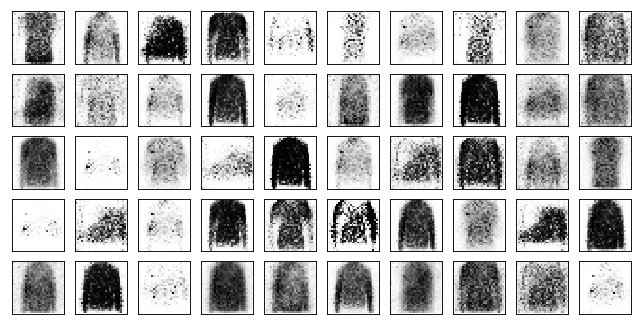

Test losses. G: 3.7228, D: 0.0688
Train Epoch: 21 [0/50000 (0%)]	Losses G: 4.2667, D: 0.1540
Train Epoch: 21 [25000/50000 (50%)]	Losses G: 4.4173, D: 0.0970
Train Epoch: 21 [50000/50000 (100%)]	Losses G: 5.2768, D: 0.1154


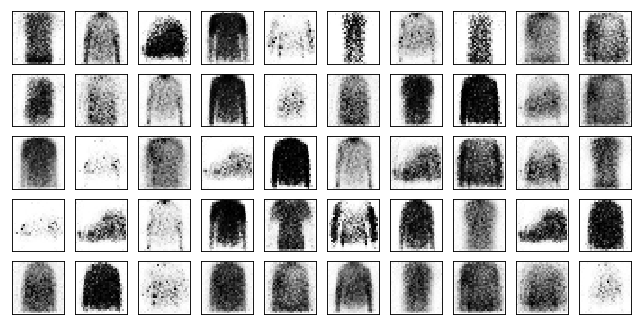

Test losses. G: 4.9211, D: 0.0410
Train Epoch: 22 [0/50000 (0%)]	Losses G: 5.3083, D: 0.0556
Train Epoch: 22 [25000/50000 (50%)]	Losses G: 4.6220, D: 0.0813
Train Epoch: 22 [50000/50000 (100%)]	Losses G: 4.1982, D: 0.1350


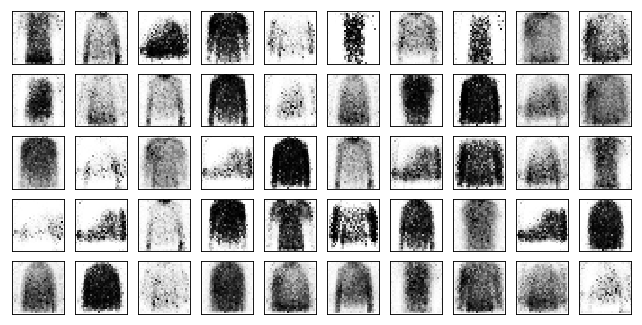

Test losses. G: 3.7140, D: 0.0757
Train Epoch: 23 [0/50000 (0%)]	Losses G: 3.7179, D: 0.1118
Train Epoch: 23 [25000/50000 (50%)]	Losses G: 3.3862, D: 0.1692
Train Epoch: 23 [50000/50000 (100%)]	Losses G: 4.2062, D: 0.1376


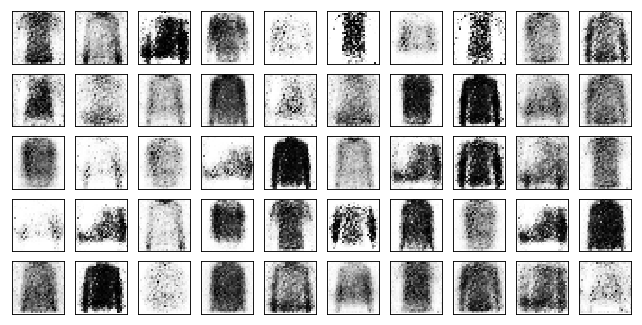

Test losses. G: 3.6345, D: 0.1113
Train Epoch: 24 [0/50000 (0%)]	Losses G: 4.6940, D: 0.1714
Train Epoch: 24 [25000/50000 (50%)]	Losses G: 4.6126, D: 0.1938
Train Epoch: 24 [50000/50000 (100%)]	Losses G: 3.0305, D: 0.1472


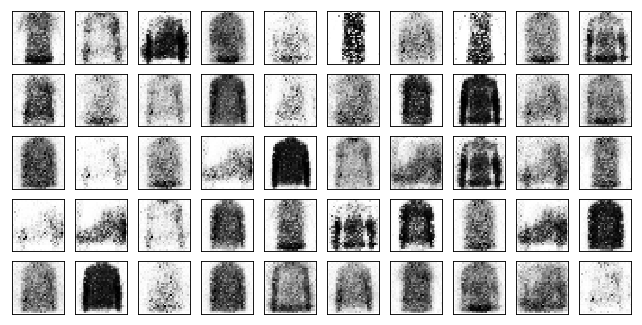

Test losses. G: 2.7966, D: 0.1077
Train Epoch: 25 [0/50000 (0%)]	Losses G: 3.3415, D: 0.1853
Train Epoch: 25 [25000/50000 (50%)]	Losses G: 4.1324, D: 0.1344
Train Epoch: 25 [50000/50000 (100%)]	Losses G: 4.7000, D: 0.0791


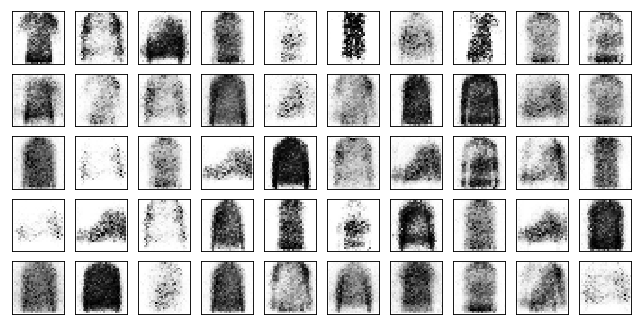

Test losses. G: 4.5564, D: 0.0377
Train Epoch: 26 [0/50000 (0%)]	Losses G: 4.7900, D: 0.0652
Train Epoch: 26 [25000/50000 (50%)]	Losses G: 3.5121, D: 0.2046
Train Epoch: 26 [50000/50000 (100%)]	Losses G: 3.8065, D: 0.3290


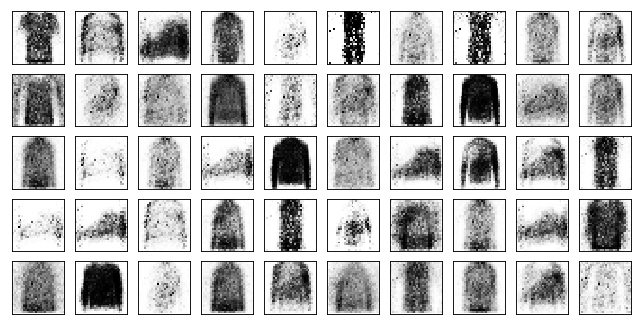

Test losses. G: 3.2865, D: 0.2054
Train Epoch: 27 [0/50000 (0%)]	Losses G: 3.8208, D: 0.2807
Train Epoch: 27 [25000/50000 (50%)]	Losses G: 4.3268, D: 0.2081
Train Epoch: 27 [50000/50000 (100%)]	Losses G: 4.6785, D: 0.1219


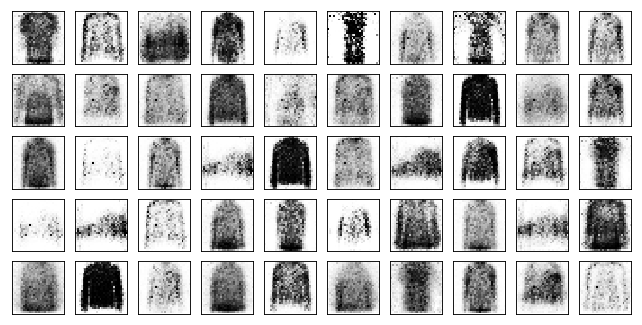

Test losses. G: 4.3532, D: 0.0741
Train Epoch: 28 [0/50000 (0%)]	Losses G: 5.0104, D: 0.1272
Train Epoch: 28 [25000/50000 (50%)]	Losses G: 4.1896, D: 0.1485
Train Epoch: 28 [50000/50000 (100%)]	Losses G: 3.6228, D: 0.1906


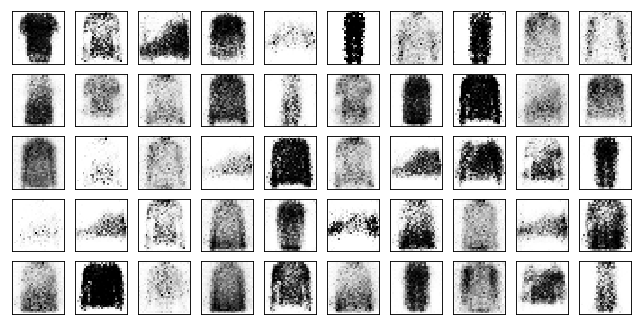

Test losses. G: 3.4527, D: 0.1072
Train Epoch: 29 [0/50000 (0%)]	Losses G: 3.7805, D: 0.1960
Train Epoch: 29 [25000/50000 (50%)]	Losses G: 3.2271, D: 0.3005
Train Epoch: 29 [50000/50000 (100%)]	Losses G: 4.5024, D: 0.1681


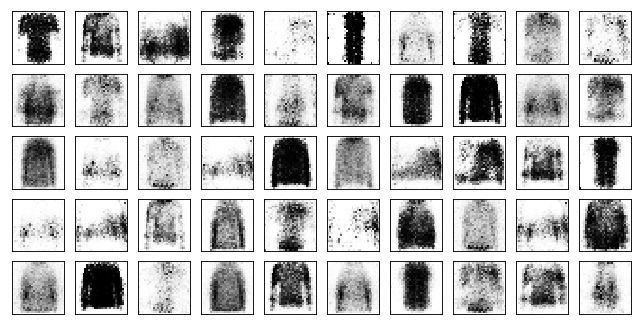

Test losses. G: 3.9139, D: 0.1167
Train Epoch: 30 [0/50000 (0%)]	Losses G: 3.6527, D: 0.1977
Train Epoch: 30 [25000/50000 (50%)]	Losses G: 4.4471, D: 0.0972
Train Epoch: 30 [50000/50000 (100%)]	Losses G: 3.8804, D: 0.1645


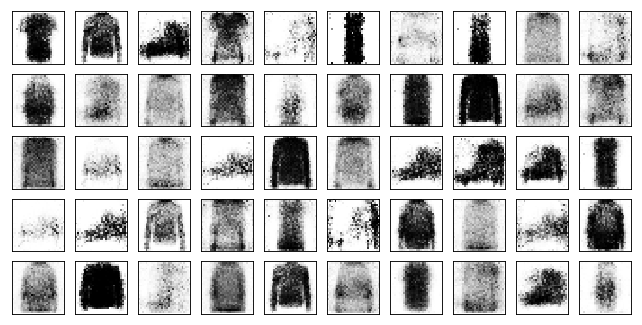

Test losses. G: 3.4159, D: 0.1251


In [29]:
for epoch in range(1, 31):
    G.train()
    D.train()
    train(epoch, G, D, train_log)
    G.eval()
    D.eval()
    test(G, D, valid_loader, epoch, test_log)